In [1]:
# essential imports
import pandas as pd
import re
import yahooquery as yq
import datetime
import numpy as np

# imports for the models
import scipy.stats as st
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
# Leggi il file CSV
df = pd.read_csv('./data/tesi28.csv', sep=';')
#pulisci i nome dei df
# sostituisci gli spazi con _ e togli le parentesi
df.columns = [re.sub(r'\(.*\)', '', col) for col in df.columns]
# Rimuovere lo spazio dagli header delle colonne alla fine e tra le parole
df.columns = df.columns.str.rstrip(' ')
df.columns = df.columns.str.rstrip('.')
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.replace('.', '')
df

## scarica i valori di borsa per ogni ticker, per ogni anno

In [ ]:
tickers = df['Ticker_symbol']
valori_borsa = []
tickers_non_scaricati=[]

# Scarica i dati storici per ciascun ticker e anno
for ticker in tickers:
    yq_ticker = yq.Ticker(ticker+".mi")
    for year in range(2023, 2013, -1):
        # Specifica la data desiderata come "YYYY-MM-DD" (31 dicembre dell'anno specificato)
        datainizio = f"{year}-01-01"
        datafine = f"{year}-01-10"
        print(ticker, year)
        # Converti la data desiderata in un oggetto datetime
        datainizio = datetime.datetime.strptime(datainizio, "%Y-%m-%d").date()
        datafine = datetime.datetime.strptime(datafine, "%Y-%m-%d").date()


        try:
            val = yq_ticker.history(start=datainizio, end=datafine)['close'][-1]
        except Exception as e:
            print(e.__cause__)
            val = "NaN"
            tickers_non_scaricati.append(ticker)

        print(ticker, val)
        valori_borsa.append(val)



In [ ]:
print(len(valori_borsa))
tickers_non_scaricati = set(tickers_non_scaricati)
print(tickers_non_scaricati)

### crea grafico di settori delle varie aziende

In [ ]:
tickers_list = list(tickers)
#print(tickers_list)
stocks_info = []
non_processed = []
for ticker in tickers_list:
    ticker = ticker+".mi"
    #print(ticker)
    yf_ticker = yq.Ticker(ticker)
    try:
        stocks_info.append({
            'ticker'    : ticker,
            'name'      : yf_ticker.quote_type[ticker]['shortName'],
            'industry'  : yf_ticker.asset_profile[ticker]['industry'],
            'sector'    : yf_ticker.asset_profile[ticker]['sector'],
        })
    except:
        non_processed.append(ticker)

print(non_processed)
t = pd.DataFrame(stocks_info)
t['name']

In [ ]:
sectors = pd.DataFrame(pd.DataFrame(t['sector'].value_counts())['count'])
industries = pd.DataFrame(pd.DataFrame(t['industry'].value_counts())['count'])
print(sectors)
print(industries)


In [ ]:
fig_sectors = px.pie(sectors, values='count', names=sectors.index, title="settori")
fig_industry = px.pie(industries, 
                    values="count",
                    names=industries.index, 
                    title="industrie",
                    height=600,
                    )
fig_sectors.show()
fig_industry.show()


## crea nuovo df
1. prendi info di interesse, moltiplica per ogni anno ogni osservazione 
2. aggiungi gli anni di interesse
3. doppio ciclo for: per ogni riga df originale prendi i primi nove valori e trasponi il risultato, passa ai prossimi nove (secondo ciclo)

#### crea df delle info 

In [ ]:
info = pd.concat([df.iloc[:, 0:5]] * 10)
info.sort_index(inplace=True)
info

#### crea colonna degli anni, aggiungi a info

In [ ]:
anni = [anno for anno in range(2022, 2012, -1)] * 28
info['Anni'] = anni
info

#### df degli indici

In [ ]:
# Rimuovi il carattere '\n' e tutti quelli che seguono dalle intestazioni delle colonne
df.columns = df.columns.str.replace(r'\n.*', '', regex=True)
df.columns = df.columns.str.rstrip('_')
nomi_colonne = df.columns.unique()[5:]
# prendi df di interesse, serve a semplificare gli indici
indici = df.iloc[:, 5:]
for i in indici.columns:
    print(i)
# crea nuovo df
new_df = pd.DataFrame()

col = 0
#per ogni set di 10 valori riga di df originario INDICI
for i in range(0, 140, 10):
    
    indice = []
    #per ogni riga AZIENDA
    for j in range(1,len(indici)+1):
        # prendi i nove valori, trasponili e aggiungili al vettore dell'indice considerato
        valori = indici.iloc[j-1:j, i:i+10].values[0]
        valori = valori.T.tolist()
        
        indice= indice + valori
        
    # aggiungi colonna a new_df con insert
    new_df.insert(col, nomi_colonne[col], indice)
    col += 1


for col in new_df.columns:
    new_df[col] = new_df[col].str.replace(',' , '.').astype(float)
    #print(type(X[col]))

new_df

#### aggiungi anche valori azionari

In [ ]:
# aggiungi i valori della borsa al df info
info['Valori_Borsa'] = valori_borsa
info

##### esegui il join dei due dataframe, resetta gli indici!!


In [ ]:
#resetta indici
info = info.reset_index(drop=True)
new_df = new_df.reset_index(drop=True)
#esegui il join
dati_puliti = info.join(new_df)
dati_puliti


### ESEGUI SE NON VUOI AZIENDE SENZA VALORI DI BORSA
##### ripulisci i dati, togli le aziende che non hanno valori di borsa per almeno un anno e calcola gli indici per ogni azienda
i valori di borsa non sono presenti in quanto alcune di queste aziende non erano quotate durante il periodo di analisi.

In [ ]:
# elimina le aziende tramite una maschera
tickers_non_scaricati = list(set(tickers_non_scaricati))
maschera = dati_puliti['Ticker_symbol'].isin(tickers_non_scaricati)
dati_puliti = dati_puliti[~maschera]
#df_pulito = df_pulito.drop(columns=["Unnamed: 0"])
dati_puliti

### ESEGUI PER SALVARE DF DELLE AZIENDE CHE NON HANNO ALCUNI VALORI DI BORSA
DF È PIÙ PICCOLO

In [ ]:
dati_puliti.to_csv("./data/dati_puliti.csv")

### ESEGUI PER SALVARE DF DI TUTTE LE AZIENDE

In [ ]:
dati_puliti.to_csv("./data/dati_puliti28.csv")

# CREA IL MODELLO
attenzione al path usato, esistono due file: uno con tutte le aziende (dati_puliti28) e uno con solo le aziende che contengono valori di borsa(dati_puliti)

In [2]:
df = pd.read_csv('./data/dati_puliti28.csv', sep=',')
df = df.drop(columns=["Unnamed: 0"])
#calcola i logaritmo dei valori di borsa
df['Valori_Borsa'] = np.log(df['Valori_Borsa'])
df

,ID,Ragione_sociale,Ticker_symbol,ISIN_number,Numero_CCIAA,Anni,Valori_Borsa,Indice_corrente,Indice_di_liquidità,Rotaz_cap_investito,...,Redditività_del_totale_attivo,Redditività_di_tutto_il_capitale_investito,Redditività_delle_vendite,Redditività_del_capitale_proprio,Indice_di_copertura_delle_immob,Costo_denaro_a_prestito,Oneri_finanz_su_fatt,Grado_di_copertura_degli_interessi_passivi,Debiti_v_banche_su_fatt,Debt_Equity_ratio
0,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2022,2.509599,1.58,1.18,1.55,...,3.44,5.34,2.22,7.77,0.45,3.79,0.50,8.11,13.25,0.95
1,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2021,2.934920,1.57,1.20,1.17,...,4.61,7.26,3.83,9.50,0.42,4.31,0.68,8.88,15.76,0.86
2,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2020,2.879198,1.70,1.38,0.98,...,0.09,0.12,0.09,-1.25,0.37,1.60,0.57,5.90,35.37,1.29
3,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2019,3.054001,1.46,1.16,1.46,...,8.84,13.31,5.88,19.42,0.33,2.15,0.40,19.02,18.59,1.04
4,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2018,3.068983,1.67,1.34,1.54,...,9.37,14.36,5.92,20.32,0.20,1.87,0.35,20.30,18.72,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2017,1.324419,3.34,3.31,0.02,...,6.48,7.48,22.97,5.28,0.03,1.42,1.13,25.64,79.55,0.35
276,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2016,1.200567,2.39,2.37,0.02,...,6.51,8.08,24.26,8.55,0.02,2.01,1.26,25.00,62.68,0.27
277,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2015,1.468335,2.55,2.53,0.02,...,7.92,9.94,29.06,13.71,0.02,3.10,1.53,23.10,49.29,0.20
278,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2014,0.816249,2.23,2.21,0.02,...,7.20,9.28,25.64,12.34,0.02,9.10,2.33,13.82,25.64,0.10


#### distribuzioni delle variabili

In [9]:
# Crea una griglia 5x3 di subplot
fig = make_subplots(rows=5, cols=3)
car_indici = []
# Cicla attraverso le colonne a partire dalla 7a
for idx, col_name in enumerate(df.columns[7:]):
    # Calcola la riga e la colonna corrispondenti nella griglia 5x3
    row = idx // 3 + 1
    col = idx % 3 + 1

    # Aggiungi un grafico a questa posizione
    histogram = px.histogram(df, x=col_name, nbins=1000)
    fig.add_trace(histogram.data[0], row=row, col=col)

    # Aggiungi titoli agli assi x e y
    fig.update_xaxes(title_text=col_name, row=row, col=col)
    fig.update_yaxes(title_text='Frequenza', row=row, col=col)

    #calcola media, min, max, dev std, 
    car_indici.append({
        'indice' : col_name,
        'media'  : df[col_name].mean(),
        'min'    : df[col_name].min(),
        'max'    : df[col_name].max(),
        'dev std': df[col_name].std(),
        'curtosi': df[col_name].kurtosis(),
        
    })

# Aggiungi un layout per personalizzare il titolo e le dimensioni
fig.update_layout(
    title='Distribuzioni degli indici',
    height=1000,  # Imposta l'altezza della griglia
    width=1200    # Imposta la larghezza della griglia
)

# Visualizza la griglia
fig.show()


In [10]:
car_indici = pd.DataFrame(car_indici)
car_indici.set_index('indice')
car_indici

,indice,media,min,max,dev std,curtosi
0,Indice_corrente,1.603643,0.52,6.46,0.900374,7.315056
1,Indice_di_liquidità,1.199250,0.42,4.70,0.595312,5.067414
2,Rotaz_cap_investito,0.791143,0.01,1.76,0.359323,0.134388
3,Rotaz_cap_cir_lordo,1.551714,0.02,3.73,0.666051,0.157719
4,Redditività_del_totale_attivo,5.260071,-5.98,18.03,4.481305,0.201944
5,Redditività_di_tutto_il_capitale_investito,8.090714,-7.93,29.80,7.130452,0.406254
6,Redditività_delle_vendite,7.085714,-8.60,29.44,6.626951,1.544859
7,Redditività_del_capitale_proprio,11.115750,-25.69,54.59,10.466850,2.398420
8,Indice_di_copertura_delle_immob,0.547071,0.01,2.96,0.541911,4.347602
9,Costo_denaro_a_prestito,4.188643,0.19,19.33,3.086145,2.819526


##### mostra le correlazioni tra i valori di borsa e tutti gli indici

In [ ]:
import seaborn as sns
correlation_matrix = df.iloc[:, 6:].corr()
# Crea una maschera per nascondere la parte superiore della matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crea una figura per il grafico
plt.figure(figsize=(12, 8))

# Personalizza l'aspetto della heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap=cmap)

# Visualizza il grafico
plt.show()

In [ ]:
for indice in df.columns[7:]:
    fig = px.scatter(df, y="Valori_Borsa", x=indice, color='Ticker_symbol')
    fig.show()

# prepara il df

In [3]:
# crea le variabili dummy
df_dummies = pd.get_dummies(df["Ticker_symbol"])
print(df_dummies)
# unsci le dummies al df
df_con_dummies = df.join(df_dummies)
df_con_dummies


       ALA    BAN     BC    BRE    CFL    CLI    DAN    ELC    ENV    FCM  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
275  False   True  False  False  False  False  False  False  False  False   
276  False   True  False  False  False  False  False  False  False  False   
277  False   True  False  False  False  False  False  False  False  False   
278  False   True  False  False  False  False  False  False  False  False   
279  False   True  False  False  False  False  False  False  False  False   

     ...   MARR   MASI    MDC    PIA    PLT    SCK    SRI  STAR7    SVS    

,ID,Ragione_sociale,Ticker_symbol,ISIN_number,Numero_CCIAA,Anni,Valori_Borsa,Indice_corrente,Indice_di_liquidità,Rotaz_cap_investito,...,MARR,MASI,MDC,PIA,PLT,SCK,SRI,STAR7,SVS,VIM
0,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2022,2.509599,1.58,1.18,1.55,...,True,False,False,False,False,False,False,False,False,False
1,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2021,2.934920,1.57,1.20,1.17,...,True,False,False,False,False,False,False,False,False,False
2,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2020,2.879198,1.70,1.38,0.98,...,True,False,False,False,False,False,False,False,False,False
3,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2019,3.054001,1.46,1.16,1.46,...,True,False,False,False,False,False,False,False,False,False
4,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2018,3.068983,1.67,1.34,1.54,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2017,1.324419,3.34,3.31,0.02,...,False,False,False,False,False,False,False,False,False,False
276,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2016,1.200567,2.39,2.37,0.02,...,False,False,False,False,False,False,False,False,False,False
277,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2015,1.468335,2.55,2.53,0.02,...,False,False,False,False,False,False,False,False,False,False
278,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2014,0.816249,2.23,2.21,0.02,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_con_dummies.columns

Construct the regression equation. Note that we are leaving out one dummy variable so as to avoid perfect Multicollinearity between the 7 dummy variables. la dummy omessa è BAN 
#RIVEDI

### definisci le variabili da usare nel modello

In [4]:
# definisce le var dipendenti e indipendenti
y_var_name = 'Valori_Borsa'
x_var_names =  [
    'Anni',
    'Indice_corrente', 
    'Indice_di_liquidità',
    'Rotaz_cap_investito', 
    'Rotaz_cap_cir_lordo',
    'Redditività_del_totale_attivo',
    'Redditività_di_tutto_il_capitale_investito',
    'Redditività_delle_vendite', 
    'Redditività_del_capitale_proprio',
    'Indice_di_copertura_delle_immob', 
    'Costo_denaro_a_prestito',
    'Oneri_finanz_su_fatt', 
    'Grado_di_copertura_degli_interessi_passivi',
    'Debiti_v_banche_su_fatt', 
    'Debt_Equity_ratio'
    ]

unit_names = [
    'MARR', 
    'PIA', 
    'BRE', 
    'DAN', 
    'BC', 
    'CLI', 
    'ELC', 
    'GPI', 
    'SRI',
    'ALA', 
    'ICF', 
    'ENV', 
    'MASI', 
    'SVS', 
    'STAR7', 
    'SCK', 
    'MARP', 
    'ITD',
    'VIM', 
    'MDC', 
    'ILP', 
    'CFL', 
    'FCM', 
    'FVI', 
    'PLT', 
    'LDB', 
    'FOS',
    'BAN'
    ]

#only_value = [x for x in unit_names if x not in tickers_non_scaricati]
#unit_names = only_value


### crea il modello

In [5]:

lsdv_expr = y_var_name + ' ~ '
i = 0
for x_var_name in x_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + x_var_name
    else:
        lsdv_expr = lsdv_expr + x_var_name
    i = i + 1
for dummy_name in unit_names[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name
 
print('Regression expression for OLS with dummies=' + lsdv_expr)

Regression expression for OLS with dummies=Valori_Borsa ~ Anni + Indice_corrente + Indice_di_liquidità + Rotaz_cap_investito + Rotaz_cap_cir_lordo + Redditività_del_totale_attivo + Redditività_di_tutto_il_capitale_investito + Redditività_delle_vendite + Redditività_del_capitale_proprio + Indice_di_copertura_delle_immob + Costo_denaro_a_prestito + Oneri_finanz_su_fatt + Grado_di_copertura_degli_interessi_passivi + Debiti_v_banche_su_fatt + Debt_Equity_ratio + MARR + PIA + BRE + DAN + BC + CLI + ELC + GPI + SRI + ALA + ICF + ENV + MASI + SVS + STAR7 + SCK + MARP + ITD + VIM + MDC + ILP + CFL + FCM + FVI + PLT + LDB + FOS


In [6]:
lsdv_model = smf.ols(formula=lsdv_expr, data=df_con_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:           Valori_Borsa   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     30.78
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           5.15e-48
Time:                        09:56:19   Log-Likelihood:                -24.819
No. Observations:                 166   AIC:                             133.6
Df Residuals:                     124   BIC:                             264.3
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### errori

In [7]:
errors = []

In [8]:
# Ottieni le previsioni per tutte le righe nel dataframe
predictions = lsdv_model_results.predict()

# trasform predictions to the original scale and the share values
predictions = np.e**predictions
val_borsa = (np.e**df['Valori_Borsa']).dropna()
#val_borsa = df['Valori_Borsa'].dropna()

rmse = np.sqrt(mean_squared_error(val_borsa, predictions))
mae = mean_absolute_error(val_borsa, predictions)
rsquared = lsdv_model_results.rsquared

# Aggiungi i dati alla lista
errors.append({
    'Formula': 'log ' + lsdv_expr,
    'RMSE': rmse,
    'MAE': mae,
    'R-Squared': rsquared,
})


In [ ]:
pd.set_option('display.max_colwidth', 2500)
errors_df = pd.DataFrame(errors)
errors_df

In [ ]:
pd.set_option('display.max_colwidth', 2500)
err = pd.read_csv("./data/errori.csv")
err

#### predictions

In [ ]:
previsioni = df[['Ticker_symbol','Anni', 'Valori_Borsa']].dropna()
previsioni['Valori_Borsa'] = np.e**previsioni['Valori_Borsa']
previsioni['predictions'] = predictions
previsioni[previsioni['Ticker_symbol']=='LDB']

#### normalità errori

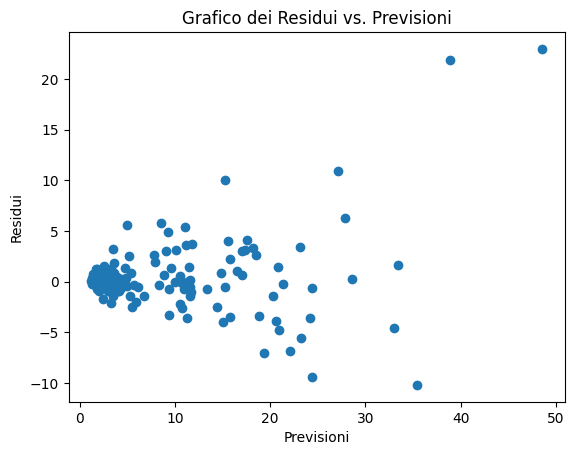

In [9]:
# Calcola i residui
residui = val_borsa - predictions

# Crea un grafico a dispersione dei residui rispetto alle previsioni
plt.scatter(predictions, residui)
plt.xlabel('Previsioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui vs. Previsioni')
plt.show()

In [10]:
from scipy.stats import shapiro

# Esegue il test di Shapiro-Wilk
statistica, p_value = shapiro(residui)

# Stampa i risultati del test
print(f'Statistica del test di Shapiro-Wilk: {statistica}')
print(f'p-value del test di Shapiro-Wilk: {p_value}')

# Confronta il p-value con un livello di significatività (e.g., 0.05)
if p_value > 0.05:
    print("Non abbiamo sufficienti prove per rifiutare l'ipotesi che i residui seguano una distribuzione normale.")
else:
    print("Rifiutiamo l'ipotesi che i residui seguano una distribuzione normale.")


Statistica del test di Shapiro-Wilk: 0.7080497741699219
p-value del test di Shapiro-Wilk: 9.111909284484853e-17
Rifiutiamo l'ipotesi che i residui seguano una distribuzione normale.


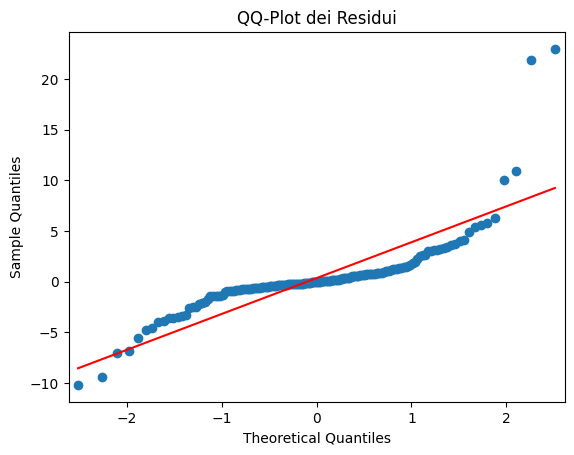

In [11]:
# Crea il QQ-plot
sm.qqplot(residui, line='s')  # 's' indica una linea di riferimento per una distribuzione normale
plt.title('QQ-Plot dei Residui')
plt.show()

### controllo che gli errori abbiamo media zero
#### prima condizione

In [16]:
# Supponiamo che tu abbia già stimato il modello e ottenuto gli errori stimati
# usando il tuo dataset e il modello 'lsdv_model_results'.

# Calcolo degli errori stimati
residuals = lsdv_model_results.resid

# Calcolo dell'aspettazione condizionata degli errori
expected_residual = residuals.mean()

print("Aspettazione condizionata degli errori:", expected_residual)


Aspettazione condizionata degli errori: -3.979764309267822e-12


### visualizza i residui 
#### seconda condizione
non essendoci pattern o strutture evidenti manca autocorrelazione

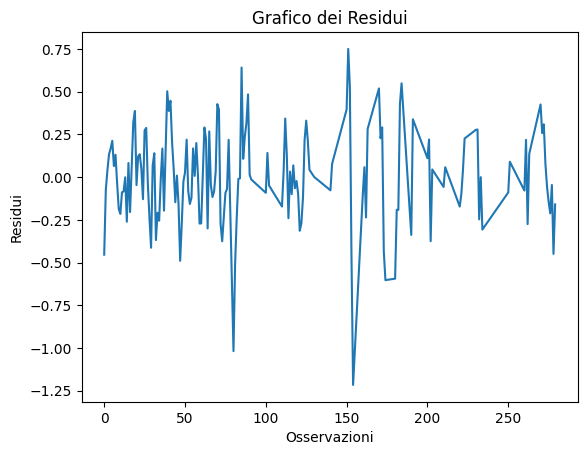

In [17]:
# Supponiamo che 'residuals' sia la serie dei residui


plt.plot(residuals)
plt.xlabel('Osservazioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui')
plt.show()


### controllo dei momenti 4i ovvero la curtosi delle distribuzioni per ogni indice
#### terza condizione